In [1]:
RANDOM_STATE = 1234

In [2]:
import numpy as np
import pandas as pd
import torch
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.AttentiveFP import AttentiveFP
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
trn = pd.read_csv("../data/processed/trn.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.csv")

trn_y, trn_X = trn["Solubility"], trn["SMILES"]
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC["SMILES"]
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC["SMILES"]
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC["SMILES"]

In [15]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
trn_X = featurizer.convert(trn_X)
tst_08SC_X = featurizer.convert(tst_08SC_X)
tst1_19SC_X = featurizer.convert(tst1_19SC_X)
tst2_19SC_X = featurizer.convert(tst2_19SC_X)

In [11]:
tune_space = {
    "dropout": hp.uniform("attn_drops", 0, 1),
    "graph_feat_size": hp.choice("graph_feat_size", [200, 400, 600]),
    "num_layers": hp.randint("num_layers", 2, 8),
    "num_timesteps": hp.randint("num_timesteps", 2, 8),
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "weight_decay": hp.uniform("weight_decay", 0, 1),
}

In [12]:
def tune_obj(space):
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    rmse = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]
        
        model = AttentiveFP(
            n_tasks=1,
            node_feat_size=featurizer.get_node_feat_size(),
            edge_feat_size=featurizer.get_edge_feat_size(),
            graph_feat_size=space["graph_feat_size"],
            num_layers=space["num_layers"],
            num_timesteps=space["num_timesteps"],
            dropout=space["dropout"],
            # General DGL Configuration
            lr=space["lr"],
            weight_decay=space["weight_decay"],
            batch_size=4096,
        )
        scores = model.fit(tX, ty,
                           val_X=vX, val_y=vy,
                           epochs=400, min_epochs=200, early_stop_epochs=10, verbose=False)
        rmse.append(scores["rmse"][-1])

    return {"loss": np.mean(rmse), 'status': STATUS_OK}

In [14]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

[DEVICE] cuda                                          
[DEVICE] cuda                                          
[DEVICE] cuda                                          
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                                       
[DEVICE] cuda                                                      

In [16]:
best_params

{'attn_drops': 0.22753620553535292,
 'graph_feat_size': 2,
 'lr': 2,
 'num_layers': 5,
 'num_timesteps': 2,
 'weight_decay': 0.0002571348715221869}

In [16]:
best_params = {
    "graph_feat_size": 600,
    "num_layers": 5,
    "num_timesteps": 2,
    "dropout": 0.2106440254404503,
    "lr": 0.001,
    "weight_decay": 0.0002571348715221869,
    "batch_size": 4096,
}

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pred_19t1, pred_19t2, pred_08t = [], [], []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X[trn_idx], trn_X[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]

    model = AttentiveFP(
        n_tasks=1,
        node_feat_size=featurizer.get_node_feat_size(),
        edge_feat_size=featurizer.get_edge_feat_size(),
        graph_feat_size=best_params["graph_feat_size"],
        num_layers=best_params["num_layers"],
        num_timesteps=best_params["num_timesteps"],
        dropout=best_params["dropout"],
        # General DGL Configuration
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        batch_size=4096,
    )

    scores = model.fit(tX, ty, val_X=vX, val_y=vy, epochs=800, min_epochs=400, early_stop_epochs=20)

    pred_19t1.append(model.predict(tst1_19SC_X).cpu())
    pred_19t2.append(model.predict(tst2_19SC_X).cpu())
    pred_08t.append(model.predict(tst_08SC_X).cpu())

[DEVICE] cuda


 63%|██████▎   | 502/800 [01:10<00:41,  7.10it/s, trn_loss:0.117 val_loss:0.202 rmse:0.698 r2:0.875]


[DEVICE] cuda


 62%|██████▏   | 495/800 [01:09<00:42,  7.12it/s, trn_loss:0.123 val_loss:0.176 rmse:0.623 r2:0.897]


[DEVICE] cuda


 56%|█████▌    | 448/800 [01:03<00:50,  7.02it/s, trn_loss:0.146 val_loss:0.220 rmse:0.741 r2:0.842]


[DEVICE] cuda


 66%|██████▌   | 528/800 [01:13<00:38,  7.15it/s, trn_loss:0.152 val_loss:0.193 rmse:0.656 r2:0.899]


[DEVICE] cuda


 63%|██████▎   | 501/800 [01:09<00:41,  7.18it/s, trn_loss:0.146 val_loss:0.220 rmse:0.707 r2:0.891]


In [36]:
pred_19t1 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t1, 1)]
pred_19t2 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t2, 1)]
pred_08t = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_08t, 1)]

In [37]:
performance = {
    "2019SC TST1 (RMSE)": mean_squared_error(tst1_19SC_y, pred_19t1, squared=False),
    "2019SC TST2 (RMSE)": mean_squared_error(tst2_19SC_y, pred_19t2, squared=False),
    "2008SC TST  (RMSE)": mean_squared_error(tst_08SC_y, pred_08t, squared=False),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y, pred_19t2),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y, pred_08t),
}
performance

{'2019SC TST1 (RMSE)': 0.8433281082616711,
 '2019SC TST2 (RMSE)': 1.4942950874574226,
 '2008SC TST  (RMSE)': 0.8108587236987512,
 '2019SC TST1 (R^2)': 0.4142558346239108,
 '2019SC TST2 (R^2)': 0.4449521380779079,
 '2008SC TST  (R^2)': 0.6429826352291494}

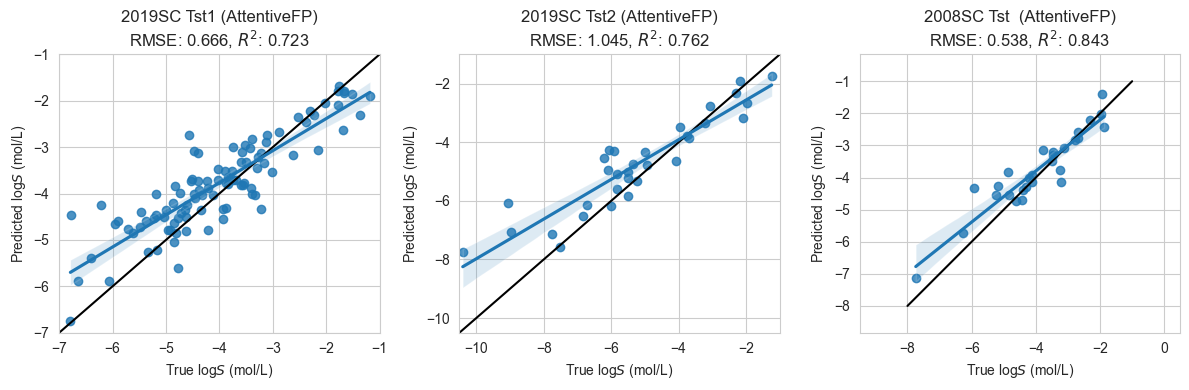

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "AttentiveFP"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -10.5, -1
min_ax3, max_ax3 = -8, -1

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")
sns.lineplot(x=[min_ax3, max_ax3], y=[min_ax3, max_ax3], ax=ax3, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst1_19SC_y.values,
        "Predicted log$S$ (mol/L)": pred_19t1
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst2_19SC_y.values,
        "Predicted log$S$ (mol/L)": pred_19t2
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax2
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst_08SC_y.values,
        "Predicted log$S$ (mol/L)": pred_08t
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax3
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)
ax3.set_xlim(min_ax3, max_ax3)
ax3.set_ylim(min_ax3, max_ax3)

ax1.set_title(f"2019SC Tst1 ({model_name})\n"
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"2019SC Tst2 ({model_name})\n"
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"2008SC Tst  ({model_name})\n"
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

plt.axis("equal")
plt.tight_layout()